<img src="storage/tf-logo-transparent.png" width=100 align="right">

<div style="font-size: large;"><b>Group Work</b> - CLEANING DATA and DEVELOPING 2 MODELS using the RBA_KYC_Accounts</div><br>
<br>
<br>
<b>Group F</b><br>
<br>
<a href="mailto:alhagbani@student.ie.edu">Abdulaziz Alhagbani</a><br>
<a href="mailto:juanbretti@student.ie.edu">Juan Pedro Bretti Mandarano</a><br>
<a href="mailto:jacob.deleon@student.ie.edu">Jacobo De Leon</a><br>
<a href="mailto:alexander.madzhirov@student.ie.edu">Aleksandar Madzhirov</a><br>
<a href="mailto:esperanza.magpantay@student.ie.edu">Esperanza Magpantay</a><br>
<a href="mailto:addison.pelayo@student.ie.edu">Addison Pelayo</a><br>
<br>
Delivery: 15/SEP/2020<br>
<br>
<a href="https://www.ie.edu/school-human-sciences-technology/masters/global-master-business-analytics-big-data/">Global Master in Business Analytics and Big Data</a> | <a href="https://www.ie.edu/">IE</a>


---

# Index


- Loading libraries

- Reading the data

- Exploratory analysis
    - General and quick analysis
    - Missing values
    - Duplicated Rows
    - Distribution using plots
    - Additional plot
        - Country plot
        - Multivariate plots

- Feature engineering
    - Add, rename and transform variables
    - Remove and filtering
    - Imputation
    - Scale

- Regression model
    - Model training
    - Performance metrics

- Classification model
    - Model training
    - Performance metrics


---

# Loading libraries

The following code, imports to the current *kernel* all the required libraries to run the code.

In [1]:
# General usage
import math
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modeling
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, recall_score, matthews_corrcoef, confusion_matrix, precision_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# https://dateutil.readthedocs.io/en/stable/relativedelta.html
from datetime import datetime
from dateutil.relativedelta import relativedelta, MO

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

---

# Reading the data

Read source data from the Excel files

In [2]:
# df = pd.read_excel('raw/RBA_KYC_Accounts_ALL_Ids.xlsx')
df_metadata_profession = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='Profession', keep_default_na=False)
df_metadata_ledgers = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='Ledgers', keep_default_na=False)
df_metadata_cus_class = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='Cus_Class', keep_default_na=False)
df_metadata_eco_sec = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='ECO_SEC', keep_default_na=False)
df_metadata_legal_sta_code = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='Legal_STA_Code', keep_default_na=False)
df_metadata_countries = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='COUNTRIES', keep_default_na=False)
df_metadata_currencies = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='Currencies', keep_default_na=False)

For speed, we had stored the Excel file in a Pickle.
https://stackoverflow.com/a/17098736/3780957

In [3]:
# df.to_pickle('storage\RBA_KYC_Accounts_ALL_Ids.pkl')
df = pd.read_pickle('storage/RBA_KYC_Accounts_ALL_Ids.pkl')

Merge data frames to have the complete country name.<br>
Using the following method https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

In [4]:
def merge_metatada(metadata, name_left, df):
    """
    Merge the main DataFrame to the additional information provided.
    :param metadata: DataFrame to be merged
    :type metadata: pd.DataFrame
    :param name_left: Name to be used from the left DataFrame
    :type name_left: str
    :param df: Main DataFrame
    :type df: pd.DataFrame
    :return: DataFrame
    :rtype: pd.DataFrame
    """
    metadata.columns = metadata.columns.str.lower()
    name_col = f'{name_left}_DescriptionENG'
    metadata[name_col] =metadata['descriptioneng']
    df = df.merge(metadata[['value', name_col]], left_on=name_left, right_on='value', how='left')
    df.drop('value', axis=1, inplace=True)
    return df

df = merge_metatada(df_metadata_profession, 'profession', df)
df = merge_metatada(df_metadata_ledgers, 'ledgerCode', df)
df = merge_metatada(df_metadata_cus_class, 'CUS_CLASS', df)
df = merge_metatada(df_metadata_eco_sec, 'ECO_SEC', df)
df = merge_metatada(df_metadata_legal_sta_code, 'LEGAL_STA_CODE', df)
df = merge_metatada(df_metadata_currencies, 'accountCurrency', df)

In [5]:
for x in ['residentCountry', 'nationalityOriginal', 'extraNationality']:
    country_x = f'{x}_CountryName'
    df_metadata_countries[country_x] = df_metadata_countries['DescriptionENG']
    df = df.merge(df_metadata_countries[['value', country_x]], left_on=x, right_on='value', how='left')
    df.drop('value', axis=1, inplace=True)

Listing the columns type, to check if the current one is correct.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225013 entries, 0 to 225012
Data columns (total 56 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   org_code                         225013 non-null  int64  
 1   branchCode                       225013 non-null  int64  
 2   customerId                       225013 non-null  int64  
 3   fullaccount                      225013 non-null  object 
 4   customerType                     225013 non-null  int64  
 5   creationDate                     225013 non-null  object 
 6   onboarding                       225013 non-null  object 
 7   residentStatus                   225013 non-null  int64  
 8   residentCountry                  224417 non-null  object 
 9   nationalityOriginal              221574 non-null  object 
 10  extraNationality                 1793 non-null    object 
 11  dateOfBirth                      220288 non-null  object 
 12  ag

Casting variables to `datetime64[ns]` and `object` (*string*).<br>
The data type of the following columns is incorrect, so we are casting the format to the appropiate one. In particular, we are converting to `object` the categorical values.

In [7]:
as_dates = ['creationDate', 'dateOfBirth', 'date_of_assessment']
for as_date in as_dates:
    df[as_date] = df[as_date].astype('datetime64[ns]')

as_objects = ['profession', 'ledgerCode', 'CUS_CLASS', 'ECO_SEC', 'LEGAL_STA_CODE', 'accountCurrency','org_code', 'branchCode', 'customerId', 'customerType', 'residentStatus', 'birthCountry', 'companyType', 'ledgerCode', 'jointAccount', 'IsBlackListed', 'CUS_CLASS', 'ECO_SEC', 'TYPE_OF_DEP', 'GENDER', 'LEGAL_STA_CODE', 'legal_Stat_desc', 'score_card_Desc']
for as_object in as_objects:
    df[as_objects] = df[as_objects].astype('object')    

---

# Exploratory analysis

We are doing some exploratory analysis of the data, to later perform actions that repairs the data.

## General and quick analysis

The following, prints the first 10 rows of the data frame.

In [8]:
df.head(n=10)

,org_code,branchCode,customerId,fullaccount,customerType,creationDate,onboarding,residentStatus,residentCountry,nationalityOriginal,...,rbaValue,profession_DescriptionENG,ledgerCode_DescriptionENG,CUS_CLASS_DescriptionENG,ECO_SEC_DescriptionENG,LEGAL_STA_CODE_DescriptionENG,accountCurrency_DescriptionENG,residentCountry_CountryName,nationalityOriginal_CountryName,extraNationality_CountryName
0,1,201,20100400550000072,020100400550015817000,2,2015-04-05,N,1,JO,JO,...,13.20,NaN,Subscribers of the bond loan of Bandar Trading...,Commercial Record,Other commercial activities,Governmental institutions outside the budget,Jordanian Dinar,Jordan,Jordan,NaN
1,1,202,20200207860000638,020200207860011330000,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,Advances of employees,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
2,1,202,20200207860000638,020200207860011389002,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,personal loan,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
3,1,202,20200207860000638,020200207860010060000,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,Classic savings,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
4,1,202,20200207860000638,020200207860010010000,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,my neighbour,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
5,1,202,20200207860000638,020200207860011355003,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,personal loan,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
6,1,202,20200207860000638,020200207860011355002,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,personal loan,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
7,1,202,20200207860000638,020200207860013284000,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,Prepaid cards,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
8,1,202,20200207860000638,020200207860011389000,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,personal loan,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
9,1,202,20200207860000638,020200207860011389001,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,personal loan,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN


Using default *pandas.DataFrame.describe()*, we perform a quick analysis of the data.<br>
Description per data type.

In [9]:
df.describe(include='object').T

,count,unique,top,freq
org_code,225013,1,1,225013
branchCode,225013,30,202,19811
customerId,225013,75339,30205511090005696,943
fullaccount,225013,220434,020902507770010010000,26
customerType,225013,2,1,199139
onboarding,225013,2,N,219936
residentStatus,225013,2,1,220241
residentCountry,224417,62,JO,219398
nationalityOriginal,221574,67,JO,213286
extraNationality,1793,35,US,1028


In [10]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
age_in_year,220288.0,41.288468,1.602056e+01,1.000000e+00,31.00,41.00,52.00,1.190000e+02
lastUpdate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_last_10_days,225013.0,7737.323798,1.325553e+06,-1.791005e+08,0.00,0.00,690.65,1.531514e+08
avg_last_30_days,225013.0,1967.704614,3.345583e+05,-4.513426e+07,0.00,0.00,182.17,3.859913e+07
avg_last_90_days,225013.0,18.556005,3.687237e+03,-4.856867e+05,0.00,0.00,1.09,4.150444e+05
number_of_cash_dep_90_days,225013.0,0.491594,5.336162e+00,0.000000e+00,0.00,0.00,0.00,1.267000e+03
avg_cash_deposit_90_days,225013.0,-1114.347668,3.027533e+04,-5.482044e+06,0.00,0.00,0.00,0.000000e+00
number_of_deposit_90_days,225013.0,1.132215,1.971166e+01,0.000000e+00,0.00,0.00,0.00,3.292000e+03
avg_of_dep_90_days,225013.0,-3551.143719,9.157115e+04,-1.654371e+07,0.00,0.00,0.00,5.867291e+05
number_of_cash_wd_90_days,225013.0,0.254168,1.175268e+00,0.000000e+00,0.00,0.00,0.00,7.800000e+01


In [11]:
df.describe(include=np.datetime64).T

,count,unique,top,freq,first,last
creationDate,225013,7041,2013-11-20,1079,1978-09-17,2018-10-21
dateOfBirth,220288,21457,1992-07-22,1035,1900-06-01,2018-10-15
date_of_assessment,225013,1,2019-01-24,225013,2019-01-24,2019-01-24


Term frequency per column for the *string* or *object* data type.

In [12]:
cat_columns = df.select_dtypes(include=['object'])
for col in cat_columns:
    print("VARIABLE =", col)
    print(df[col].value_counts())
    print('\n'*2)

VARIABLE = org_code
1    225013
Name: org_code, dtype: int64



VARIABLE = branchCode
202    19811
208    15974
704    12882
701    11332
805    10428
801     9262
502     8870
206     8598
207     8458
403     7673
501     7556
354     7483
209     7453
402     7339
702     7001
205     6674
401     6653
601     6046
351     5958
802     5782
302     5716
803     5494
356     5378
203     5097
204     5083
804     4525
357     4355
603     4245
404     3691
201      196
Name: branchCode, dtype: int64



VARIABLE = customerId
30205511090005696    943
35108255290001427    723
20702061400001087    700
20600229290003418    513
2060022929           513
                    ... 
50100883400009812      1
80226319540000685      1
40300964530010243      1
70100835120014104      1
70424507790000129      1
Name: customerId, Length: 75339, dtype: int64



VARIABLE = fullaccount
020902507770010010000    26
020301298000011930001    23
020301298000012969000    23
020301298000012957000    23
020301298

Jordanian Dinar      214789
Us Dollar              8489
Euro                   1081
Pound Sterling          254
Uae Dirham               93
Canadian Dollar          81
Saudi Riyal              60
Yen                      41
Swiss Franc              40
Australian Dollar        37
Silver                   15
Gold                     11
Sweden Krone              9
Qatari Rial               4
Newzelend Dollar          3
Danish Krone              2
Bahrain Dinar             1
Lebanese Lira             1
Spanish Peseta            1
Kuwaiti Dinar             1
Name: accountCurrency_DescriptionENG, dtype: int64



VARIABLE = residentCountry_CountryName
Jordan                                  219398
Oman                                       985
Iraq                                       981
Saudi Arabia                               657
United States                              358
United Arab Emirates                       313
Syrian Arab Republic                       264
Libyan Arab Jamahi

## Missing values

Checking for percentage (%) of missing values per column.

In [13]:
missing_values = 100*df.isnull().sum()/df.isnull().count()
missing_values.round(1).sort_values(ascending=False)

score_card_Desc                    100.0
birthCountry                       100.0
giinCode                           100.0
lastUpdate                         100.0
legal_Stat_desc                    100.0
extraNationality_CountryName        99.4
extraNationality                    99.2
profession                          64.6
profession_DescriptionENG           64.6
GENDER                              53.6
companyType                         49.0
birthPlace                           9.8
ledgerCode_DescriptionENG            7.5
dateOfBirth                          2.1
age_in_year                          2.1
nationalityOriginal_CountryName      1.5
nationalityOriginal                  1.5
LEGAL_STA_CODE_DescriptionENG        1.2
LEGAL_STA_CODE                       1.2
residentCountry                      0.3
residentCountry_CountryName          0.3
accountCurrency_DescriptionENG       0.0
CUS_CLASS_DescriptionENG             0.0
ECO_SEC_DescriptionENG               0.0
rbaValue        

Same revision, using a plot

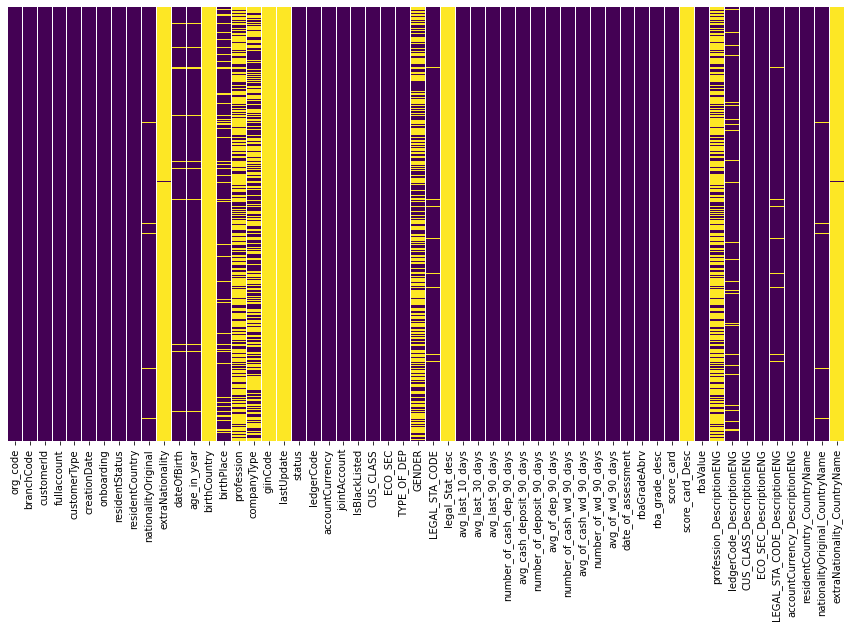

In [14]:
# https://towardsdatascience.com/using-pandas-method-chaining-to-improve-code-readability-d8517c5626ac
df2 = df.isnull()
plt.figure(figsize=(15,8))
sns.heatmap(df2, yticklabels=False, cbar=False, cmap='viridis')

Quick glipse of the null or missing values in the dataset

In [15]:
df.head(n=10).style.highlight_null(null_color='red')

,org_code,branchCode,customerId,fullaccount,customerType,creationDate,onboarding,residentStatus,residentCountry,nationalityOriginal,extraNationality,dateOfBirth,age_in_year,birthCountry,birthPlace,profession,companyType,giinCode,lastUpdate,status,ledgerCode,accountCurrency,jointAccount,IsBlackListed,CUS_CLASS,ECO_SEC,TYPE_OF_DEP,GENDER,LEGAL_STA_CODE,legal_Stat_desc,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,date_of_assessment,rbaGradeAbrv,rba_grade_desc,score_card,score_card_Desc,rbaValue,profession_DescriptionENG,ledgerCode_DescriptionENG,CUS_CLASS_DescriptionENG,ECO_SEC_DescriptionENG,LEGAL_STA_CODE_DescriptionENG,accountCurrency_DescriptionENG,residentCountry_CountryName,nationalityOriginal_CountryName,extraNationality_CountryName
0,1,201,20100400550000072,020100400550015817000,2,2015-04-05 00:00:00,N,1,JO,JO,nan,NaT,nan,nan,nan,nan,35.000000,nan,nan,Active,5817,JOD,0,0,4,46,35,nan,2.000000,nan,8610000.000000,2170000.000000,23333.330000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,2019-01-24 00:00:00,L,Low,E-Existing,nan,13.200000,nan,Subscribers of the bond loan of Bandar Trading Company,Commercial Record,Other commercial activities,Governmental institutions outside the budget,Jordanian Dinar,Jordan,Jordan,nan
1,1,202,20200207860000638,020200207860011330000,1,2013-09-17 00:00:00,N,1,JO,JO,nan,1989-06-30 00:00:00,30.000000,nan,????,27.000000,nan,nan,nan,Active,1330,JOD,0,0,2,90,23,2.000000,1.000000,nan,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,2019-01-24 00:00:00,L,Low,I-Existing,nan,16.930000,Banker,Advances of employees,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,nan
2,1,202,20200207860000638,020200207860011389002,1,2013-09-17 00:00:00,N,1,JO,JO,nan,1989-06-30 00:00:00,30.000000,nan,????,27.000000,nan,nan,nan,Active,1389,JOD,0,0,2,90,23,2.000000,1.000000,nan,-137562.720000,-34672.520000,-369.810000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,2019-01-24 00:00:00,L,Low,I-Existing,nan,16.930000,Banker,personal loan,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,nan
3,1,202,20200207860000638,020200207860010060000,1,2013-09-17 00:00:00,N,1,JO,JO,nan,1989-06-30 00:00:00,30.000000,nan,????,27.000000,nan,nan,nan,Active,60,JOD,0,0,2,90,23,2.000000,1.000000,nan,2079.790000,526.870000,6.680000,4,-550.000000,4,-550.000000,1,50.000000,1,50.000000,2019-01-24 00:00:00,L,Low,I-Existing,nan,16.930000,Banker,Classic savings,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,nan
4,1,202,20200207860000638,020200207860010010000,1,2013-09-17 00:00:00,N,1,JO,JO,nan,1989-06-30 00:00:00,30.000000,nan,????,27.000000,nan,nan,nan,Active,10,JOD,0,0,2,90,23,2.000000,1.000000,nan,444.000000,120.500000,0.950000,4,-540.000000,4,-540.000000,1,56.000000,1,56.000000,2019-01-24 00:00:00,L,Low,I-Existing,nan,16.930000,Banker,my neighbour,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,nan
5,1,202,20200207860000638,020200207860011355003,1,2013-09-17 00:00:00,N,1,JO,JO,nan,1989-06-30 00:00:00,30.000000,nan,????,27.000000,nan,nan,nan,Active,1355,JOD,0,0,2,90,23,2.000000,1.000000,nan,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,2019-01-24 00:00:00,L,Low,I-Existing,nan,16.930000,Banker,personal loan,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,nan
6,1,202,20200207860000638,020200207860011355002,1,2013-09-17 00:00:00,N,1,JO,JO,nan,1989-06-30 00:00:00,30.000000,nan,????,27.000000,nan,nan,nan,Active,1355,JOD,0,0,2,90,23,2.000000,1.000000,nan,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,2019-01-24 00

In [16]:
total_null = df.isnull().sum().sum()
total_null_ratio = (total_null/(df.shape[0]*df.shape[1])).round(2)

print(f'There are {total_null} missing values in the dataset')
print(f'That is a ratio of {total_null_ratio*100}% missing')


There are 2154964 missing values in the dataset
That is a ratio of 17.0% missing


## Duplicated Rows

The dataset has 145 duplicated rows before we begin the cleansing part. Below is a sample where some records have 100% duplications in all columns:

In [17]:
pd.set_option('display.max_columns',100)
df[df.duplicated(keep=False)][:4].style.apply(lambda x: ['background: lightcoral' 
                                  if (x.name == 73078 or x.name == 73079)
                                  else 'background: lightblue' for i in x], axis=1)

,org_code,branchCode,customerId,fullaccount,customerType,creationDate,onboarding,residentStatus,residentCountry,nationalityOriginal,extraNationality,dateOfBirth,age_in_year,birthCountry,birthPlace,profession,companyType,giinCode,lastUpdate,status,ledgerCode,accountCurrency,jointAccount,IsBlackListed,CUS_CLASS,ECO_SEC,TYPE_OF_DEP,GENDER,LEGAL_STA_CODE,legal_Stat_desc,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,date_of_assessment,rbaGradeAbrv,rba_grade_desc,score_card,score_card_Desc,rbaValue,profession_DescriptionENG,ledgerCode_DescriptionENG,CUS_CLASS_DescriptionENG,ECO_SEC_DescriptionENG,LEGAL_STA_CODE_DescriptionENG,accountCurrency_DescriptionENG,residentCountry_CountryName,nationalityOriginal_CountryName,extraNationality_CountryName
73078,1,356,35609319960001616,035609319960015301000,2,2012-10-07 00:00:00,N,1,JO,JO,nan,2012-10-08 00:00:00,7.000000,nan,nan,nan,54.000000,nan,nan,Active,5301,JOD,0,0,4,359,54,nan,2.000000,nan,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,2019-01-24 00:00:00,L,Low,E-Existing,nan,15.200000,nan,Collectible check depositors / clients,Commercial Record,Chemical industry and derivatives,Governmental institutions outside the budget,Jordanian Dinar,Jordan,Jordan,nan
73079,1,356,35609319960001616,035609319960015301000,2,2012-10-07 00:00:00,N,1,JO,JO,nan,2012-10-08 00:00:00,7.000000,nan,nan,nan,54.000000,nan,nan,Active,5301,JOD,0,0,4,359,54,nan,2.000000,nan,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,2019-01-24 00:00:00,L,Low,E-Existing,nan,15.200000,nan,Collectible check depositors / clients,Commercial Record,Chemical industry and derivatives,Governmental institutions outside the budget,Jordanian Dinar,Jordan,Jordan,nan
73080,1,356,35609319960001616,035609319960010010000,2,2012-10-07 00:00:00,N,1,JO,JO,nan,2012-10-08 00:00:00,7.000000,nan,nan,nan,54.000000,nan,nan,Active,10,JOD,0,0,4,359,54,nan,2.000000,nan,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,2019-01-24 00:00:00,L,Low,E-Existing,nan,15.200000,nan,my neighbour,Commercial Record,Chemical industry and derivatives,Governmental institutions outside the budget,Jordanian Dinar,Jordan,Jordan,nan
73081,1,356,35609319960001616,035609319960010010000,2,2012-10-07 00:00:00,N,1,JO,JO,nan,2012-10-08 00:00:00,7.000000,nan,nan,nan,54.000000,nan,nan,Active,10,JOD,0,0,4,359,54,nan,2.000000,nan,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,2019-01-24 00:00:00,L,Low,E-Existing,nan,15.200000,nan,my neighbour,Commercial Record,Chemical industry and derivatives,Governmental institutions outside the budget,Jordanian Dinar,Jordan,Jordan,nan


## Distribution using plots

Histogram of all the numeric variables.

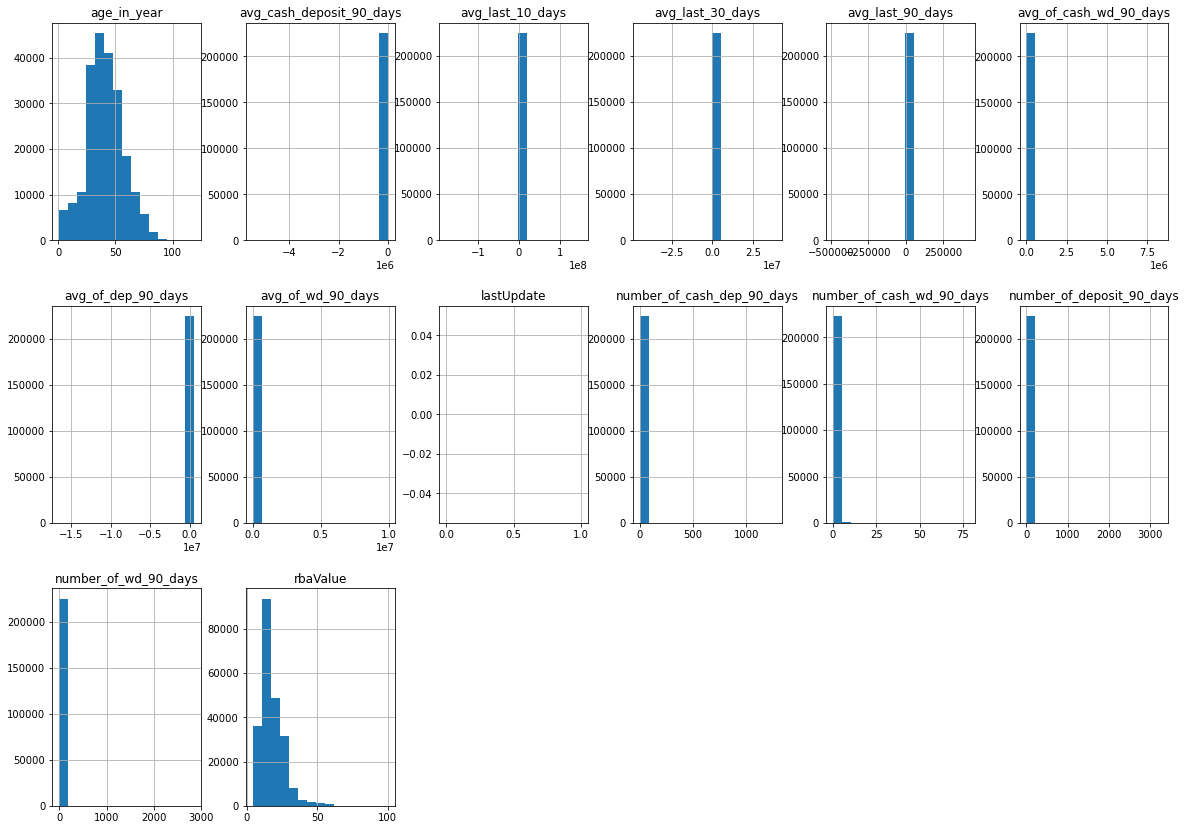

In [18]:
df.select_dtypes(include=['int64', 'float64']).hist(bins=15, figsize=(20, 30), layout=(6, 6));

Boxplot of all the numeric variables.<br>
The following are showing we need to work on the data distribution.

In [19]:
# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/#xaxis.set_visiblefalse%2fyaxis.set_visiblefalse-to-hide-axis-including-axis-label

def boxplot_manual(data):
    """
    Creates a trellis of boxplots based on the DataFrame provided.
    :param data: Source DataFrame
    :type data: pd.DataFrame
    :return: None
    :rtype: None
    """
    num_cols = 3
    num_rows = math.ceil(len(data.columns)/num_cols)
    fig, axs = plt.subplots(num_rows, num_cols)
    fig.set_size_inches(20, 20)

    for subplot, column in enumerate(data.columns, 0):
        x, y = int(subplot / num_cols), subplot % num_cols
        data_ = data[column].dropna()
        axs[x, y].boxplot(data_, vert=False)
        axs[x, y].set_title(f"Column '{column}'")
        axs[x, y].axes.yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

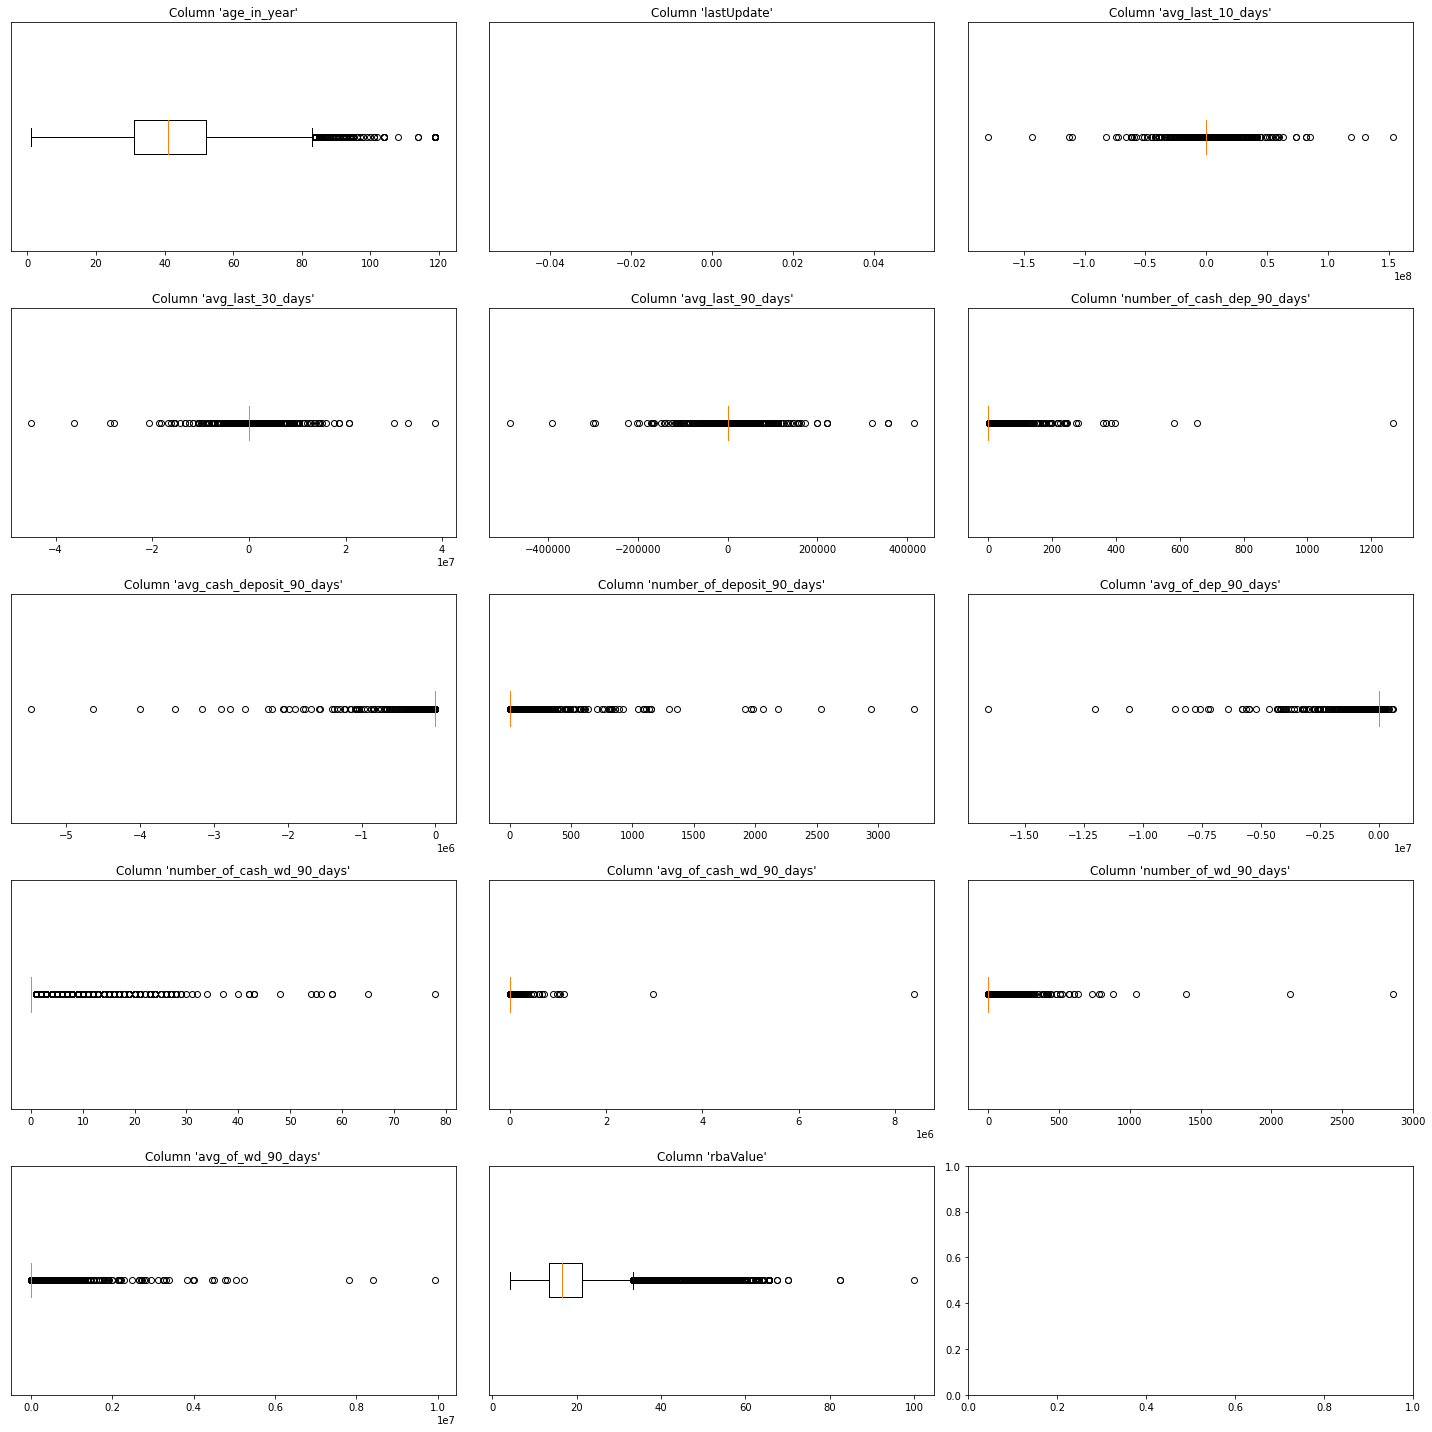

In [20]:
# https://stackoverflow.com/a/62011115/3780957
with np.errstate(invalid='ignore'):
    boxplot_manual(df.select_dtypes(include=['int64', 'float64']))

## Additional plot

### Country plot

Showing the `avg_last_90_days` per `residentCountry`. Are only detailed the firs 6 countries, and the reminder are aggregated in a category `Others`.

In [21]:
def get_flag(name, width_size=20):
    """
    Downloads the country flags from GitHub of in case of failure, from a local drive.
    It resize all the images to a width defined by "width_size")
    :param name: ISO2 country name
    :type name: str
    :param width_size: Width in pixels
    :type width_size: int
    :return: Flag image
    :rtype: matplotlib.offsetbox object
    """
    try:
        path = "https://raw.githubusercontent.com/google/region-flags/gh-pages/png/{}.png".format(name)
        im = plt.imread(path)
        zoom_ = width_size/im.shape[1]
        img = OffsetImage(im, zoom=zoom_)
        # print('{}: {} then {}'.format(name, im.shape, img))
    except:  # In case the images cannot be downloaded from GitHub, gets from local drive
        path = "storage/region-flags-gh-pages-png/40x40/{}.png".format(name)
        im = plt.imread(path)
        zoom_ = width_size/im.shape[1]
        img = OffsetImage(im, zoom=zoom_)
        # print('From local drive: {} size {}'.format(name, im.shape))
    return img

def offset_image(coord, name, ax):
    """
    Place the image inside the plot passed at 'ax'.
    :param coord: Position on x (horizontal axis)
    :type coord: int
    :param name: Name of the country (ISO 2)
    :type name: str
    :param ax: subplot
    :type ax: object
    :return: Plot
    :rtype: obj
    """
    im = get_flag(name)
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord, 0), xybox=(0., -16.), frameon=False, xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)

def plot_bar_countries(df, countries, valuesA, nlargest=10):
    """
    Plots the mean of 'valuesA' per 'countries'
    :param df: DataFrame with the source of data
    :type df: pandas.DataFrame
    :param countries: Name of the column to be use to extract the countries
    :type countries: str
    :param valuesA: Name of the column to be use to extract the numeric value to average
    :type valuesA: str
    :param nlargest: Number of elements to show as columns
    :type nlargest: int
    :return: plot
    :rtype: obj
    """
    bottom_countries = df.groupby(countries).mean().sort_values(by=valuesA, ascending=False)[nlargest:].index.values
    df2 = df.replace(bottom_countries, 'Others').groupby(countries).mean().sort_values(by=valuesA, ascending=False)

    fig, ax = plt.subplots()

    ax.bar(range(len(df2.index.values)), df2[valuesA], width=0.5, align="center")
    ax.set_xticks(range(len(df2.index.values)))
    ax.set_xticklabels(df2.index.values)
    ax.tick_params(axis='x', which='major', pad=26)

    for i, c in enumerate(df2.index.values):
        offset_image(i, c, ax)

    plt.show()

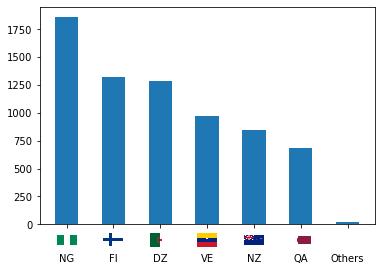

In [22]:
plot_bar_countries(df, 'residentCountry', 'avg_last_90_days', 6)

### Multivariate plots

Displaying a violin plot to show the probability density for `Gender` against `age_in_year`, hued by the `score_card` as well as the `rba_grade_desc`.

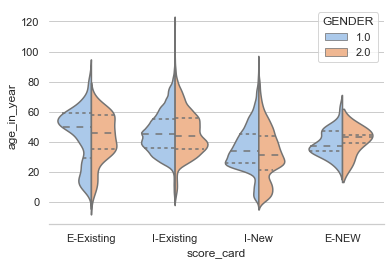

In [23]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="score_card", y="age_in_year",  hue="GENDER",
               split=True, inner="quart",
               data=df)
sns.despine(left=True)

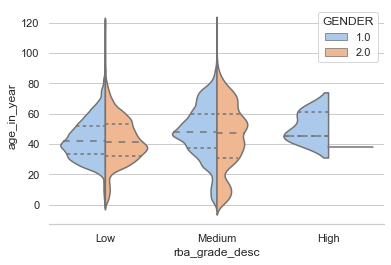

In [24]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="rba_grade_desc", y="age_in_year",  hue="GENDER",
               split=True, inner="quart",
               data=df)
sns.despine(left=True)

Displaying a scatter plot to show the relationship between `age_in_year` and `avg_of_cash_wd_90_days`, hued by the `CUS_CLASS_DescriptionENG`.

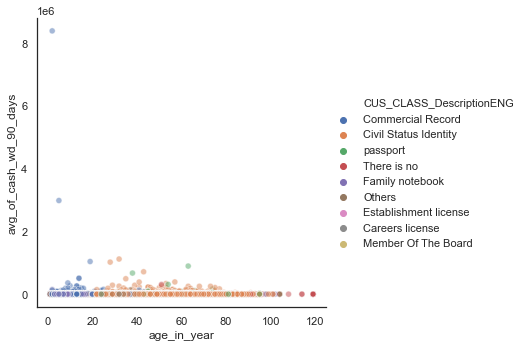

In [25]:
sns.set(style="white")

ax = sns.relplot(x="age_in_year", 
            y="avg_of_cash_wd_90_days", 
            hue="CUS_CLASS_DescriptionENG", 
            alpha=0.5, 
            data=df)

Displaying a ridgeline plot to show the distribution of `age_in_year` for `LEGAL_STA_CODE_DescriptionENG` categories.

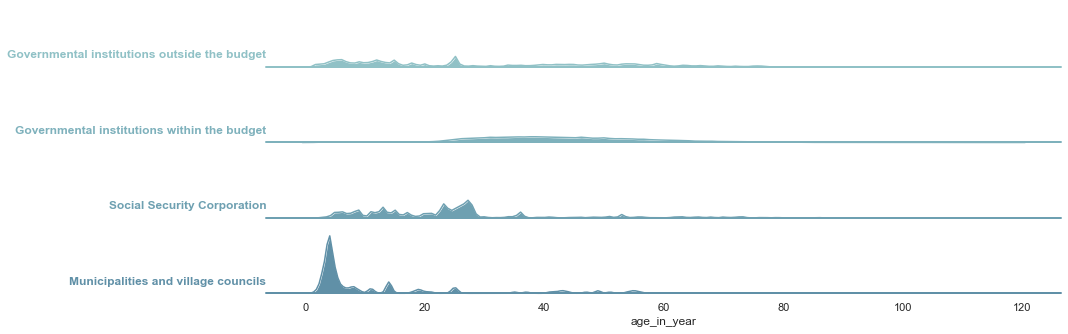

In [26]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="LEGAL_STA_CODE_DescriptionENG", hue="LEGAL_STA_CODE_DescriptionENG", 
                  aspect=12, height=1.25, palette=pal)


g.map(sns.kdeplot, "age_in_year", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="right", va="center", transform=ax.transAxes)
g.map(label, "age_in_year")


g.fig.subplots_adjust(hspace=.25)


g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

---

# Feature engineering

## Add, rename and transform variables

Rename the column `rba_grade_desc`.

In [27]:
df['Risk_Description'] = df['rba_grade_desc']
df.drop(['rba_grade_desc'], axis = 1, inplace = True) 

Creating the variable `creationDate_indays`

In [28]:
df['creationDate_indays'] = df['creationDate'].max()-df['creationDate']

Creating the variable `dateOfBirth`

In [29]:
def f(end):
    """
    Difference in year to the sourced date.
    :param end: Date to be differenced.
    :type end: datetime64[ns]
    :return: Years
    :rtype: int
    """
    global max_date
    try:
        r = relativedelta(max_date, end) 
        return(r.years)
    except:
        return(0)

max_date = df['dateOfBirth'].max()
df['age'] = df['dateOfBirth'].apply(f)

Converts first character of each word to uppercase and remaining to lowercase.<br>
Also the whitespaces are being removed.

In [30]:
cat_columns = df.select_dtypes(include=['object']).columns

for var in cat_columns:
    df.loc[:, var] = df.loc[:, var].astype('str').str.strip().str.title()

Correct the missing variants in the `birthPlace`.<br>
This variable has multiple rows containing spurious characters.

In [31]:
df['birthPlace'].value_counts()

????              76333
?????             38750
??????            29918
Nan               21987
???????           19467
                  ...  
??? ????? /???        1
108447                1
Tissamaharama         1
Baddegama             1
Rajbari               1
Name: birthPlace, Length: 929, dtype: int64

In [32]:
out = []
for val in df['birthPlace']:
    try:
        if val.find('?')>=0 or val.strip()=='0':
            out.append('-')
        else:
            out.append(val)
    except:
        out.append(val)

df['birthPlace'] = out

Add missing values to the additional information column `extraNationality`.<br>
The column `extraNationality` even after having a high level of missing values, should be kept, because it adds additional information to the custumer.

In [33]:
df.loc[df['extraNationality'].isna(), 'extraNationality'] = 'None'

## Remove and filtering

Some examples to be consider to be removed or filtered:<br>
More than 50% of the `GENDER` values are nulls. We remove the entire variable, or replace it with the mode (Male).<br>
Another way is to use kNN imputation with another predictive variable (Profession) as it somehow gives indictions for the gender, but it suffers from high percentage of missing values (64%).<br>
Since only 1% of the variable `LEGAL_STA_CODE` values is missing, and the dominating value is 1 (85%), it is advisable to replace the missing values with the mode. <br>
100% of the variable `legal_Stat_desc` is missing, therefore the entire variable will be removed from the dataset.<br>
No missing values at `avg_last_10_days`. The variable is a continuous number with both negative and positive values. Zero makes up 41% of total values. <br>
No missing values at `avg_last_30_days`. The variable is a continuous number with both negative and positive values. Zero makes up 42% of total values. <br>
No missing values at `avg_last_90_days`. The variable is a continuous number with both negative and positive values. Zero makes up 50% of total values. <br>
No missing values at `number_of_cash_dep_90_days`. The variable is a continuous number with positive values. Zero makes up 89% of total values. <br>
There are few notable outliers, some are suspicious such as (1267) total number of deposit within just 90 days.<br>
No missing values at `avg_cash_deposit_90_days`. The variable is a continuous number with negative values. Zero makes up 89% of total values. <br>
There are few notable outliers, but they look fine.<br>
No missing values at `number_of_deposit_90_days`. The variable is a continuous number with positive values. Zero makes up 86% of total values.

Remove full *NA* columns

In [34]:
# Drop columns where all the values are missing or null
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
print(f'Shape before {df.shape}')
df.dropna(axis='columns', how='all', inplace=True)
print(f'Shape after {df.shape}')

Shape before (225013, 58)
Shape after (225013, 57)


Remove constant value columns

In [35]:
col_unique = df.columns[df.nunique()==1]
col_unique

Index(['org_code', 'birthCountry', 'status', 'IsBlackListed',
       'legal_Stat_desc', 'date_of_assessment', 'score_card_Desc'],
      dtype='object')

In [36]:
print(f'Shape before {df.shape}')
df.drop(col_unique, axis=1, inplace=True)
print(f'Shape after {df.shape}')

Shape before (225013, 57)
Shape after (225013, 50)


Remove high cardinality columns.<br>
This means, high number of unique elements in the variable.

In [37]:
cardinality_list = df.apply(pd.Series.nunique)/df.shape[0]*100
cardinality_list.round(1).sort_values(ascending=False)

fullaccount                        98.0
avg_last_10_days                   47.3
avg_last_30_days                   41.9
customerId                         33.5
avg_last_90_days                   16.7
dateOfBirth                         9.5
avg_of_dep_90_days                  5.0
avg_of_wd_90_days                   3.9
creationDate                        3.1
creationDate_indays                 3.1
avg_cash_deposit_90_days            2.6
avg_of_cash_wd_90_days              2.4
rbaValue                            0.3
birthPlace                          0.2
ECO_SEC                             0.1
number_of_cash_dep_90_days          0.1
number_of_deposit_90_days           0.1
number_of_wd_90_days                0.1
ledgerCode_DescriptionENG           0.1
ECO_SEC_DescriptionENG              0.1
ledgerCode                          0.1
age_in_year                         0.0
accountCurrency                     0.0
extraNationality                    0.0
nationalityOriginal                 0.0


`fullaccount` has a very high cardinality. That's why the column is being removed.

In [38]:
print(f'Shape before {df.shape}')
df.drop(['fullaccount'], axis=1, inplace=True)
print(f'Shape after {df.shape}')

Shape before (225013, 50)
Shape after (225013, 49)


Remove columns with high ratio of missing values.<br>
In this example, the threshold is set to **80%** of the number of total rows.<br>
https://stackoverflow.com/a/50798593/3780957

In [39]:
na_threshold = len(df) * .80

print(f'Shape before {df.shape}')
df = df.dropna(thresh=na_threshold, axis=1)
print(f'Shape after {df.shape}')

Shape before (225013, 49)
Shape after (225013, 49)


Remove duplicate rows.<br>
To achieve the following, we are using two methods from *Pandas*.
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html

In [40]:
print(f'Number of duplicates {df.duplicated().sum()} rows to be removed')
df.drop_duplicates(inplace=True)

Number of duplicates 13520 rows to be removed


Remove highly correlated columns

In [41]:
#https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "4pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

cmap = cmap = sns.diverging_palette(5, 250, as_cmap=True)
corr = df.corr()
corr.style.background_gradient(cmap="Greens", axis=1)\
    .set_properties(**{'max-width': '80px','max-height': '100px', 'font-size': '1pt'})\
    .set_caption("Hover to magnify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,age_in_year,avg_last_10_days,avg_last_30_days,avg_last_90_days,number_of_cash_dep_90_days,avg_cash_deposit_90_days,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,rbaValue,age
age_in_year,1.00,0.02,0.02,0.02,-0.03,0.02,-0.03,0.03,0.01,-0.01,-0.02,-0.02,0.06,1.00
avg_last_10_days,0.02,1.00,1.00,0.98,0.00,0.01,0.06,-0.03,0.00,0.01,0.02,0.00,0.01,0.01
avg_last_30_days,0.02,1.00,1.00,0.98,0.00,0.01,0.06,-0.03,0.00,0.01,0.02,0.00,0.01,0.01
avg_last_90_days,0.02,0.98,0.98,1.00,0.00,0.01,0.06,-0.03,0.00,0.01,0.01,-0.00,0.01,0.01
number_of_cash_dep_90_days,-0.03,0.00,0.00,0.00,1.00,-0.59,0.42,-0.36,0.09,0.02,0.36,0.36,0.03,-0.03
avg_cash_deposit_90_days,0.02,0.01,0.01,0.01,-0.59,1.00,-0.28,0.47,-0.05,-0.02,-0.26,-0.45,-0.04,0.02
number_of_deposit_90_days,-0.03,0.06,0.06,0.06,0.42,-0.28,1.00,-0.36,0.06,0.03,0.39,0.34,0.04,-0.03
avg_of_dep_90_days,0.03,-0.03,-0.03,-0.03,-0.36,0.47,-0.36,1.00,-0.05,-0.20,-0.43,-0.61,-0.04,0.04
number_of_cash_wd_90_days,0.01,0.00,0.00,0.00,0.09,-0.05,0.06,-0.05,1.00,0.15,0.17,0.10,-0.05,0.01
avg_of_cash_wd_90_days,-0.01,0.01,0.01,0.01,0.02,-0.02,0.03,-0.20,0.15,1.00,0.03,0.45,0.02,-0.01


In [42]:
# https://stackoverflow.com/a/63536382/3780957

def corrFilter(x: pd.DataFrame, bound: float):
    """
    Filters the provided DataFrame based on the threshold defined at 'bound' parameter.
    :param x: Source DataFrame
    :type x: pd.DataFrame
    :param bound: Threshold to limit the correlation.
    :type bound: float
    :return: Filtered DataFrame
    :rtype: pd.DataFrame
    """
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

cor_ = corrFilter(df, .8)
cor_

avg_last_30_days  avg_last_90_days    0.975413
avg_last_10_days  avg_last_90_days    0.977172
                  avg_last_30_days    0.998307
age_in_year       age                 0.999681
                  age_in_year              NaN
dtype: float64

In [43]:
# https://stackoverflow.com/a/25733562/3780957
print(f'Shape before {df.shape}')
df.drop(cor_.reset_index()['level_1'], axis=1, inplace=True)
print(f'Shape after {df.shape}')

Shape before (211493, 49)
Shape after (211493, 45)


## Imputation

Replacing the missing value of a column with the *mean* or *mode* (for *numeric*, *string* or *date*), and also creating variables to highlight the replacement.<br>
Meaning 1 when original variable is missing and 0 otherwise.

In [44]:
# Mean fill for missing values
num_columns = df.select_dtypes(include=['int64', 'float64']).columns
num_feats = df.loc[:, num_columns]

for var in num_columns:
    if sum(1*num_feats[var].isnull()):
        print(var, 'has missings')
        mean_ = num_feats[var].mean()
        num_feats.loc[num_feats[var].isnull(), var] = mean_
        num_feats[var+'_missing'] = 1*num_feats[var].isnull()

In [45]:
# Mode fills for missing values
cat_columns = df.select_dtypes(include=['object', 'datetime64']).columns
cat_feats = df.loc[:, cat_columns]

for var in cat_columns:
    if sum(1*cat_feats[var].isnull()):
        print(var, 'has missings')
        mode_ = cat_feats[var].mode().iloc[0]
        cat_feats.loc[cat_feats[var].isnull(), var] = mode_
        cat_feats[var+'_missing'] = 1*cat_feats[var].isna()

dateOfBirth has missings


Feature engineering for the dates.<br>
Adding segregation of the date value to be used in the modelling phase.

In [46]:
df_time = pd.DataFrame()
for col in df.select_dtypes(include=['datetime64']):
    df_time['{}_year'.format(col)] = df[col].dt.year
    df_time['{}_month'.format(col)] = df[col].dt.month
    df_time['{}_day'.format(col)] = df[col].dt.day
    df_time['{}_dayofyear'.format(col)] = df[col].dt.dayofyear

Finally, the result of imputing both: *numerical*, *categorical* and *date*, is now merged together in a single Dataset.

In [47]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
df = pd.concat([cat_feats, num_feats, df_time], axis=1, sort=False)

Drop rows with remaining *NA*

In [48]:
print(f'Shape before {df.shape}')
df.dropna(axis='rows', how='any', inplace=True)
print(f'Shape after {df.shape}')

Shape before (211493, 53)
Shape after (207255, 53)


## Scale

Scale all the numeric values, at this point.

In [49]:
# https://stackoverflow.com/a/36475297/3780957

num_columns = df.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
df[num_columns] = scaler.fit_transform(df[num_columns])

In [50]:
df.columns

Index(['branchCode', 'customerId', 'customerType', 'creationDate',
       'onboarding', 'residentStatus', 'residentCountry',
       'nationalityOriginal', 'extraNationality', 'dateOfBirth', 'birthPlace',
       'profession', 'companyType', 'giinCode', 'ledgerCode',
       'accountCurrency', 'jointAccount', 'CUS_CLASS', 'ECO_SEC',
       'TYPE_OF_DEP', 'GENDER', 'LEGAL_STA_CODE', 'rbaGradeAbrv', 'score_card',
       'profession_DescriptionENG', 'ledgerCode_DescriptionENG',
       'CUS_CLASS_DescriptionENG', 'ECO_SEC_DescriptionENG',
       'LEGAL_STA_CODE_DescriptionENG', 'accountCurrency_DescriptionENG',
       'residentCountry_CountryName', 'nationalityOriginal_CountryName',
       'extraNationality_CountryName', 'Risk_Description',
       'dateOfBirth_missing', 'avg_last_10_days', 'number_of_cash_dep_90_days',
       'avg_cash_deposit_90_days', 'number_of_deposit_90_days',
       'avg_of_dep_90_days', 'number_of_cash_wd_90_days',
       'avg_of_cash_wd_90_days', 'number_of_wd_90_days

---

# Regression model

## Model training

Developed a regression model using `rbaValue` as target variable.

In [51]:
y = df['rbaValue']
X = df.drop('rbaValue', axis=1)

Encoded the categorical variables to *dummy variables*.

In [52]:
X = OneHotEncoder(drop='first').fit_transform(X)

Split the data into train and test.<br>
Then fitting a *linear regression* model to predict the `rbaValue`.

In [53]:
# https://github.com/renero/class_notebooks/blob/master/Linear%20regression.ipynb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

## Performance metrics

For Linear Regression the most important model performance metrics are *R2 Score*, *RMSE* and *Mean Absolute Percentage Error (MAPE)*.<br>
The closer *R2 Score* is to 1 the more accurate our model.<br>
*RMSE* and *MAPE* should be low for a good model.</h4>

In [54]:
print('Intercept:', lm.intercept_)
print('Coefficients:', lm.coef_)
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('Variance score (R2): {:.2f}'.format(r2_score(y_test, y_pred)))
print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Mean Absolute Percentage Error: {:.2f}'.format(np.mean(np.abs((y_test - y_pred) / y_test)) * 10))

Intercept: 4.095567645265705
Coefficients: [-0.03014199 -0.01624239 -0.04270865 ... -0.01278725  0.01526518
 -0.08261784]
Mean squared error (MSE): 0.03
Variance score (R2): 0.97
Mean Absolute Error: 0.07
Root Mean Squared Error: 0.16
Mean Absolute Percentage Error: 4.55


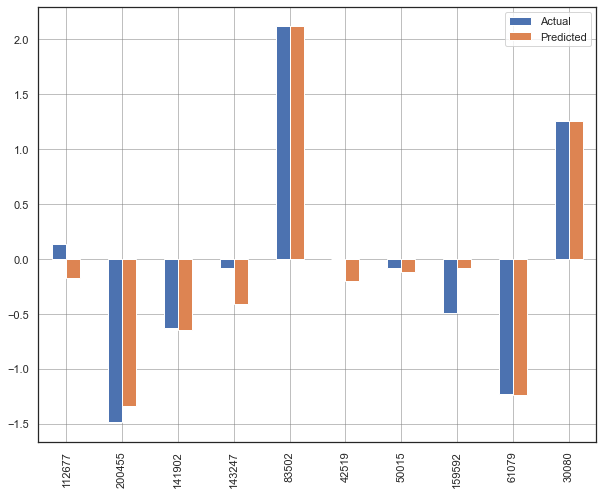

In [55]:
result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

result1 = result[:10]
result1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

---

# Classification model

## Model training

Binary Classification model using `Risk_Description` setting `Risk_Description` = Low as 0 and else 1 (Medium or High). <br>

In [56]:
# Merge the categories 'Medium' and 'High'
y = df['Risk_Description']
y = [0 if x=='Low' else 1 for x in y]
# pd.Series(y).value_counts()

X = df.drop('Risk_Description', axis=1)

Encoded the categorical variables to *dummy variables*.

In [57]:
X = OneHotEncoder(drop='first').fit_transform(X)

Split the data into train and test.<br>
Then fitting a *logistic regression* model to predict the `Risk_Description`.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

## Performance metrics

Model assestment using the proper metrics for a classification model.

In [59]:
# Calculating the confusion matrix 
# Saving confusion matrix and slice into four pieces
confusion = confusion_matrix(y_test, y_pred)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print(f"Confusion matrix:\n{confusion}")

# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[30253     0]
 [    0 11198]]

Normalized confusion matrix:
[1. 0.]
[0. 1.]


<p>The confusion matrix is a more accurate metric for model performance. We can decide whether our model is ideal or not based on which sections of the confusion matrix we want to maximize. For example, in health related predictions false positives should be minimum.</p>

In [60]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
specificity = TN / (TN + FP)
false_positive_rate = FP / float(TN + FP)
precision = precision_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('F1:', f1)
print('Recall:', recall)
print("Matthew's Correlation Coefficient:", mcc)
print('Classification error:', 1 - accuracy_score(y_test, y_pred))
print('Specificity:', specificity)
print('False Positive Rate:', false_positive_rate)
print('Precision:', precision)

Accuracy: 1.0
F1: 1.0
Recall: 1.0
Matthew's Correlation Coefficient: 1.0
Classification error: 0.0
Specificity: 1.0
False Positive Rate: 0.0
Precision: 1.0
